## Importing Libraries : 

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from scipy.stats import chisquare

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from statsmodels.iolib.summary2 import summary_col
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Reading the Dataset:

Reading the 'lawsuit' dataset using pandas

In [22]:
lawsuit = pd.read_csv('/Users/rak/Desktop/ML_Coursework/lawsuit.csv')

In [23]:
lawsuit.head()

,ID,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Sal94,Sal95
0,1,1,1,0,0,7.4,9,3,77836,84612
1,2,1,1,0,0,6.7,10,2,69994,78497
2,3,1,1,0,0,8.1,6,1,62872,67756
3,4,1,1,1,1,5.1,27,3,155196,173220
4,5,1,1,0,0,7.0,10,3,89268,96099


In [24]:
lawsuit.shape

(261, 10)

In [25]:
lawsuit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      261 non-null    int64  
 1   Dept    261 non-null    int64  
 2   Gender  261 non-null    int64  
 3   Clin    261 non-null    int64  
 4   Cert    261 non-null    int64  
 5   Prate   261 non-null    float64
 6   Exper   261 non-null    int64  
 7   Rank    261 non-null    int64  
 8   Sal94   261 non-null    int64  
 9   Sal95   261 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 20.5 KB


## Data Cleaning :


In [6]:
lawsuit.isna().sum()

ID        0
Dept      0
Gender    0
Clin      0
Cert      0
Prate     0
Exper     0
Rank      0
Sal94     0
Sal95     0
dtype: int64

This datset appears to have no null values.  

Dropping 'ID' column as it is not relevant in our analysis:

In [26]:
lawsuit = lawsuit.drop(columns=["ID"])

### Exploratory Data Analysis:

Plotting number of females and males in the dataset:

Text(0, 0.5, 'Count')

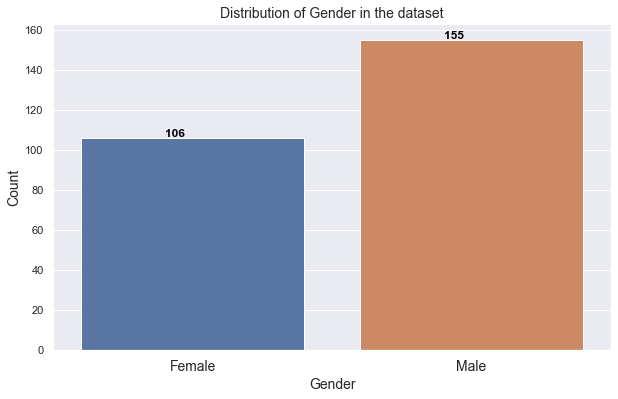

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x="Gender", data=lawsuit)



for i, v in enumerate(lawsuit.groupby("Gender").size()):
    v=round(v,2)
    ax.text(i - 0.1, v + 0.5, str(v), color='black', fontweight='bold',fontsize = 12)
plt.title("Distribution of Gender in the dataset", fontsize = 14)
plt.xticks([0, 1], ['Female', 'Male'],fontsize = 14)
ax.set_xlabel('Gender',fontsize = 14)
ax.set_ylabel('Count',fontsize = 14)

Plotting a graph to show mean salary in 1994 for Males and Females:

Text(0, 0.5, 'Mean Salary')

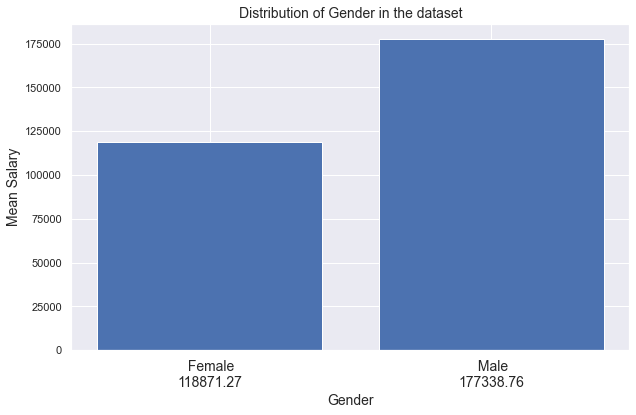

In [28]:
fig, ax = plt.subplots(figsize=(10,6))

values = np.round(lawsuit.groupby("Gender")["Sal94"].mean().values,2)
ax.bar([0,1],values)
plt.title("Distribution of Gender in the dataset", fontsize = 14)
plt.xticks([0, 1], [f" Female\n{values[0]}", f" Male\n{values[1]}"],fontsize = 14)
ax.set_xlabel('Gender',fontsize = 14)
ax.set_ylabel('Mean Salary',fontsize = 14)

The male faculty members in this dataset have higher average salary than males. However, this does not mean that there is evidence of gender discrimination at the college as the mean salary is dependant on numerous factors.

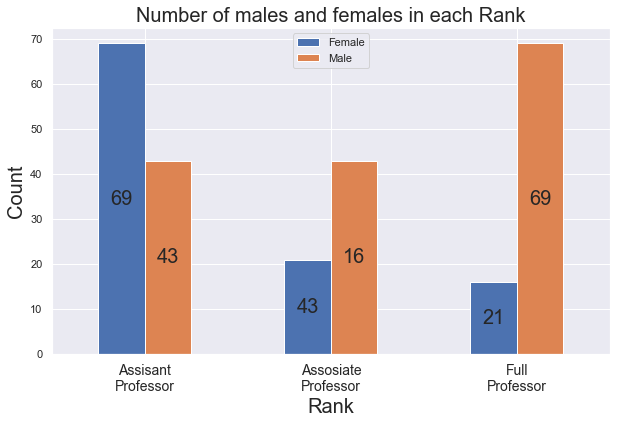

In [29]:

# group data by Rank and Gender, and count the number of occurrences
grouped = lawsuit.groupby(['Rank', 'Gender']).size().reset_index(name='Count')

# create a pivot table to reshape the data
pivoted = pd.pivot_table(grouped, values='Count', index='Rank', columns='Gender')

pivoted.columns = ['Female', 'Male']
pivoted.index = ['Assisant\nProfessor', 'Assosiate\nProfessor', 'Full\nProfessor']
# plot the data as a grouped bar chart
ax = pivoted.plot(kind='bar', stacked=False, figsize=(10,6))
# add label values to each bar
for i, patch in enumerate(ax.patches):
    ax.text(patch.get_x() + patch.get_width()/2, patch.get_y() + patch.get_height()/2, 
            pivoted.values.flatten()[i], ha='center', va='center')
plt.xticks(fontsize=14,rotation=0)
plt.title('Number of males and females in each Rank')
plt.xlabel('Rank')
plt.ylabel('Count')
plt.show()


#### Creating Correlation Heatmap:

<AxesSubplot:>

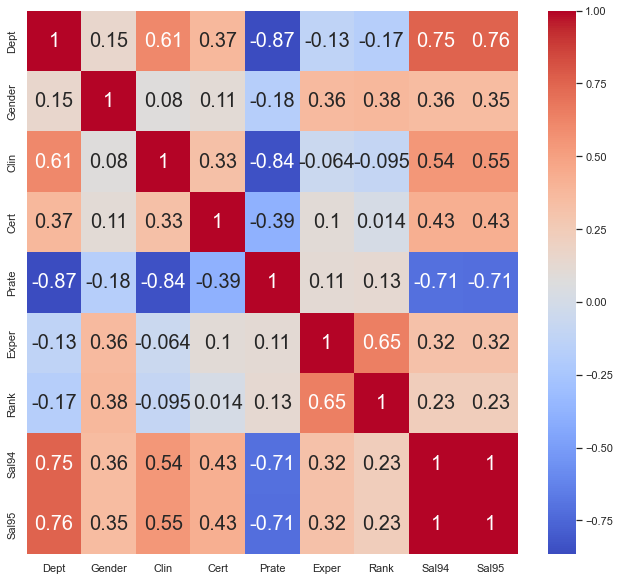

In [30]:
# Create the correlation matrix
corr_matrix = lawsuit.corr()

# Visualize the correlation matrix using heatmap from seaborn
plt.figure(figsize=(11,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

The correlation matrix shows correlation between pairs of all variables in the dataset and allows us to see with variables are correlated with each other. 

We can see that the two salary variables ( Sal94 and Sal95 ) are highly correlated with Dept and Prate. 
However it is important to note that salary is negatively correlated with Prate which would suggest that as publication rate increases the employee's salary decreases.

Interestingly the heatmap reveals that salary is not highly correlated with gender.

To better understand the relationship that categorical variables have with each other we can create a scatterplot matrix:

In [31]:
# Dropping Sal95:
lawsuit = lawsuit.drop(columns = ['Sal95'])


#### Creating Scatterplot Matrix:

The scatterplot matrix reveals the relationship each variable has with the Sal94 variable which we will try and predict.

This shows that: 
1. Certain departments have significantly higher salaries.
2. The is a visable difference in the salaries of men and women with men earning much higher salaries.
3. There are fewer women with higher salaries as compared to men.
4. Employees with Primary Clinical Emphasis have high top salaries.
5. Employees with Board Certification have high top salaries.
6. Supports previous conclusion about Prate. Highest salaries with employees with lowest Prate.
7. Experience does not seem to be a determining factor in predicting salary.

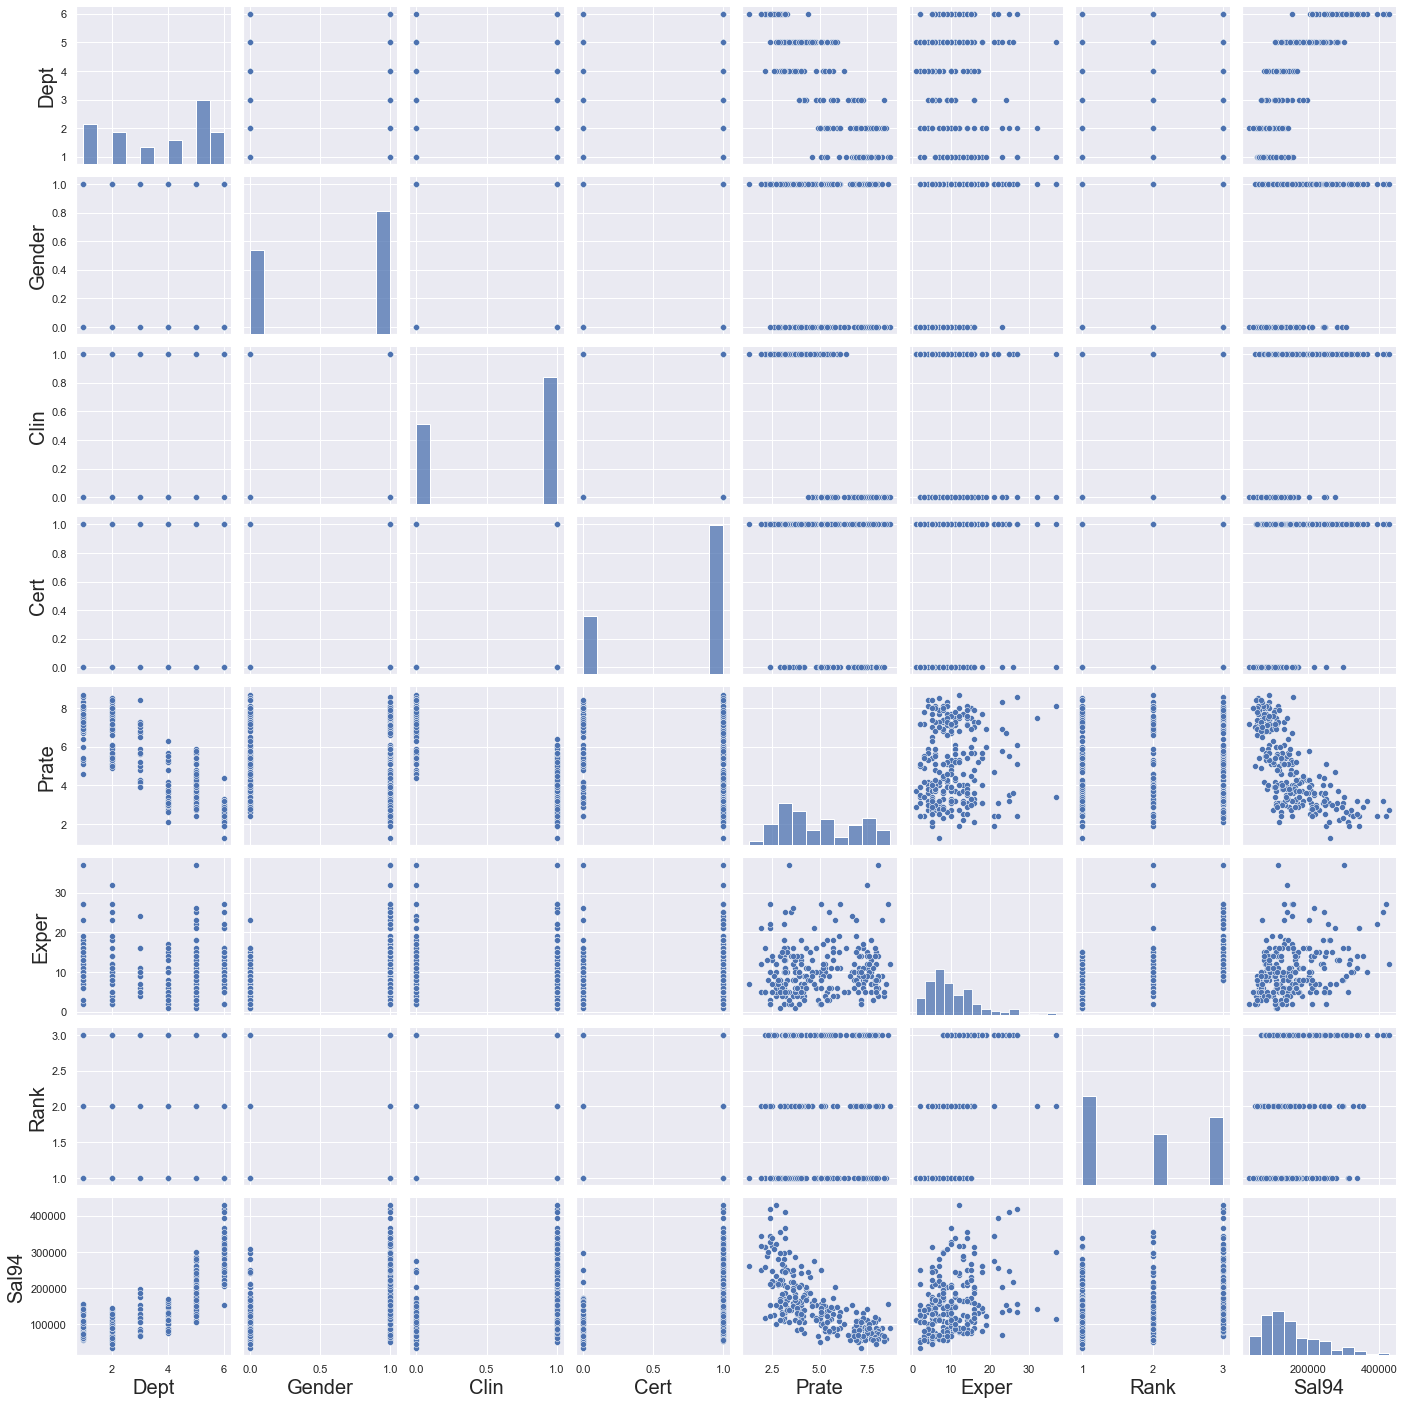

In [19]:
sns.set(rc={'axes.labelsize': 20, 'font.size': 20, 'axes.titlesize': 20})
plt = sns.pairplot(lawsuit)

### Unsupervised Learning:

#### Using K Means Clustering to determine if gender is an important differentiator :

In [33]:
# Scaling the data to make standard deviation 1:
scaler = StandardScaler()
scaled_lawsuit = scaler.fit_transform(lawsuit)

# Creating emoty dataframe:
k2_result = pd.DataFrame()

k2 = KMeans(n_clusters = 2, random_state = 42)
k2.fit(scaled_lawsuit)

# Creating lists to store gender, 1994 salary and cluster label of each entry in the dataset:
gender = lawsuit['Gender']
sal94 = lawsuit [ 'Sal94']
cluster = k2.labels_

# Adding gender salary and cluster label to results dataframe:
k2_result.insert(0,"Gender",gender)
k2_result.insert(1,"Salary94",sal94)
k2_result.insert(2,"Cluster",cluster)

k2_result


,Gender,Salary94,Cluster
0,1,77836,0
1,1,69994,0
2,1,62872,0
3,1,155196,0
4,1,89268,0
...,...,...,...
256,0,297174,1
257,0,308081,1
258,0,211269,1
259,0,210801,1


In [34]:
# grouping the k2_result to create clusters:
cluster1= k2_result.loc[k2_result['Cluster']==0]
cluster2= k2_result.loc[k2_result['Cluster']==1]

print(cluster1)
print(cluster2)

# Grouping each cluster by gender to find proportion:

# Calculating number of males and females:
genderprop1 = cluster1["Gender"].value_counts()
genderprop2 = cluster2["Gender"].value_counts()
#Calculating proportion:
genderprop1 = round(genderprop1/len(cluster1),2)
genderprop2 = round(genderprop2/len(cluster2),2)

print("Gender Proportion for Cluster 1:")
print(genderprop1)
print("\n")
print("Gender Proportion for Cluster 2:")
print(genderprop2)

     Gender  Salary94  Cluster
0         1     77836        0
1         1     69994        0
2         1     62872        0
3         1    155196        0
4         1     89268        0
..      ...       ...      ...
157       1    172793        0
175       1    129499        0
215       0    204279        0
219       0    123940        0
220       0    107524        0

[116 rows x 3 columns]
     Gender  Salary94  Cluster
50        1     97707        1
92        1    123859        1
94        1    174479        1
95        1    196704        1
96        1    186953        1
..      ...       ...      ...
256       0    297174        1
257       0    308081        1
258       0    211269        1
259       0    210801        1
260       0    244551        1

[145 rows x 3 columns]
Gender Proportion for Cluster 1:
1    0.5
0    0.5
Name: Gender, dtype: float64


Gender Proportion for Cluster 2:
1    0.67
0    0.33
Name: Gender, dtype: float64


In my first cluster, it appears that the distribution of gender is almost equal. However in the second cluster the distribution of gender is almost 2/3 male and only 1/3 female.

Now the mean salaries of each of the clusters will be calculated in order to see the effect gender has on salary.

In [35]:
# Calculating mean salary of each cluster:
print("Salary Statistics for Cluster 1:")
print(cluster1['Salary94'].describe())
print("\n")
print("Salary Statistics for Cluster 2:")
print(cluster2['Salary94'].describe())

Salary Statistics for Cluster 1:
count       116.000000
mean      94444.784483
std       31074.050930
min       34514.000000
25%       69701.750000
50%       89955.500000
75%      113207.250000
max      204279.000000
Name: Salary94, dtype: float64


Salary Statistics for Cluster 2:
count       145.000000
mean     200912.193103
std       76469.591676
min       77087.000000
25%      142249.000000
50%      182945.000000
75%      247953.000000
max      428876.000000
Name: Salary94, dtype: float64


The results clearly show that the mean and meadian salary for cluster 2 (which has a significantly higher proportion of males) is noticibley higher than the mean and median salary of cluster 1.

In [36]:


from scipy.stats import chi2_contingency

# create a contingency table of observed counts
observed = pd.crosstab(k2_result['Cluster'], k2_result['Gender'])

# run the chi-square test
chi2, p, dof, expected = chi2_contingency(observed)

# print the results
print("Chi-square test statistic:", chi2)
print("p-value:", p)

Chi-square test statistic: 6.9437834753499645
p-value: 0.008411101908943548


The Chi-square test statistic (in this case) is a measure of the differences in the gender proportions  between the two clusters. A CHi-square test statistic of 4.7 indicates that that there is a differnces. A p value lower than the chosen significance level (usually 0.05) means that we reject the null hypothesis and can conlude that there is a statistically significant difference is the proportions of gender between the two clusters.

### Supervised Learning :

### Regression Models:

Q1 : Is gender a significant predictor of a faculty member's salary?

To answer this question, 3 regression model - linear regression, random forest regressor and lasso regression will be used to to determine the importance of all the features on the prediction of salary.

##### Creating Dummy variables for categorical columns:

In [37]:
# Creating Dummy Variables for Regression Models:
dummy_data = pd.get_dummies(lawsuit, columns=['Dept', 'Gender', 'Clin', 'Cert', 'Rank'], drop_first=True)
dummy_data

,Prate,Exper,Sal94,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6,Gender_1,Clin_1,Cert_1,Rank_2,Rank_3
0,7.4,9,77836,0,0,0,0,0,1,0,0,0,1
1,6.7,10,69994,0,0,0,0,0,1,0,0,1,0
2,8.1,6,62872,0,0,0,0,0,1,0,0,0,0
3,5.1,27,155196,0,0,0,0,0,1,1,1,0,1
4,7.0,10,89268,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2.9,8,297174,0,0,0,0,1,0,1,1,1,0
257,2.6,9,308081,0,0,0,0,1,0,1,1,0,1
258,2.8,8,211269,0,0,0,0,1,0,1,1,0,0
259,2.4,2,210801,0,0,0,0,1,0,1,1,0,0


##### Scaling continous data to improve model performance:

In [38]:
# Select only the continuous columns
num_cols = ['Prate', 'Exper']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the selected columns
dummy_data[num_cols] = scaler.fit_transform(dummy_data[num_cols])

dummy_data

,Prate,Exper,Sal94,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6,Gender_1,Clin_1,Cert_1,Rank_2,Rank_3
0,1.271611,-0.197882,77836,0,0,0,0,0,1,0,0,0,1
1,0.910916,-0.036987,69994,0,0,0,0,0,1,0,0,1,0
2,1.632305,-0.680567,62872,0,0,0,0,0,1,0,0,0,0
3,0.086472,2.698227,155196,0,0,0,0,0,1,1,1,0,1
4,1.065500,-0.036987,89268,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,-1.047139,-0.358777,297174,0,0,0,0,1,0,1,1,1,0
257,-1.201722,-0.197882,308081,0,0,0,0,1,0,1,1,0,1
258,-1.098667,-0.358777,211269,0,0,0,0,1,0,1,1,0,0
259,-1.304778,-1.324147,210801,0,0,0,0,1,0,1,1,0,0


#### Linear Regression:

In [39]:
# Creating Target variable and features:
X_lin= dummy_data.drop(columns =['Sal94'])
Y_lin= dummy_data['Sal94']

lr= LinearRegression()
lr.fit(X_lin,Y_lin)

pred_lin = lr.predict(X_lin)
r2_lin = r2_score(Y_lin,pred_lin)
rmse_lin = np.sqrt(mean_squared_error(Y_lin,pred_lin))

print(" R2 value is : ",r2_lin)
print(" rmse value is : ",rmse_lin)

 R2 value is :  0.9040524579173693
 rmse value is :  24878.00494555392


In [40]:
# Add constant to X to include the intercept term in the model
X = sm.add_constant(X_lin)

# Train a linear regression model
model = sm.OLS(Y_lin, X_lin).fit()

# Print the summary of the model, including the p-values
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Sal94   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              851.4
Date:                Sun, 02 Apr 2023   Prob (F-statistic):                   1.83e-194
Time:                        16:25:19   Log-Likelihood:                         -3030.9
No. Observations:                 261   AIC:                                      6086.
Df Residuals:                     249   BIC:                                      6129.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [41]:
# Print the summary table with p-values formatted to display 5 decimal places
results_summary = summary_col([model], float_format='%0.5f', stars=True)
print(results_summary)


                    Sal94     
------------------------------
Prate          28673.61172*** 
               (3299.35040)   
Exper          15277.12720*** 
               (2246.92907)   
Dept_2         -5127.63836    
               (5843.89520)   
Dept_3         44345.95588*** 
               (6982.52778)   
Dept_4         67612.66275*** 
               (7262.57115)   
Dept_5         114380.92606***
               (5843.76904)   
Dept_6         226393.88899***
               (7864.12000)   
Gender_1       5193.81413     
               (3907.48609)   
Clin_1         52769.73628*** 
               (5503.63160)   
Cert_1         23308.38445*** 
               (4304.56812)   
Rank_2         24273.23533*** 
               (4679.52001)   
Rank_3         41914.75506*** 
               (5211.38060)   
R-squared      0.97621        
R-squared Adj. 0.97506        
Standard errors in
parentheses.
* p<.1, ** p<.05, ***p<.01


#### Random Forest Regressor:

In [42]:
# Creating Target and Feature variables for random forest model:
X_forest = dummy_data.drop(columns=['Sal94'])
Y_forest = lawsuit['Sal94']

X_forest

,Prate,Exper,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6,Gender_1,Clin_1,Cert_1,Rank_2,Rank_3
0,1.271611,-0.197882,0,0,0,0,0,1,0,0,0,1
1,0.910916,-0.036987,0,0,0,0,0,1,0,0,1,0
2,1.632305,-0.680567,0,0,0,0,0,1,0,0,0,0
3,0.086472,2.698227,0,0,0,0,0,1,1,1,0,1
4,1.065500,-0.036987,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
256,-1.047139,-0.358777,0,0,0,0,1,0,1,1,1,0
257,-1.201722,-0.197882,0,0,0,0,1,0,1,1,0,1
258,-1.098667,-0.358777,0,0,0,0,1,0,1,1,0,0
259,-1.304778,-1.324147,0,0,0,0,1,0,1,1,0,0


In [43]:
rf = RandomForestRegressor(n_estimators=500, max_features=3, random_state=2)
# Fitting the model:
rf.fit(X_forest,Y_forest)

# Get the feature importances
importances = rf.feature_importances_
# Creating DataFrame to store Feature importance
result_forest = pd.DataFrame()
feature_names = ['Publication Rate', 'Experience',"physiology", 'Genetics', 'Pediatrics','Medicine','Surgery','Gender:Male','clinical emphasis','Certified','Assosiate Prof','Profesor']
result_forest["Feature Name"] = feature_names
result_forest["Score"] = importances
# Sorting scores in descending order:
result_forest = result_forest.sort_values(by='Score', ascending=False)
result_forest

,Feature Name,Score
6,Surgery,0.275742
0,Publication Rate,0.240379
1,Experience,0.124971
8,clinical emphasis,0.097270
5,Medicine,0.067319
11,Profesor,0.049469
9,Certified,0.048387
7,Gender:Male,0.030526
2,physiology,0.029365
4,Pediatrics,0.021325


In [44]:
# calculating R-squared value
forest_pred = rf.predict(X_forest)
r2_forest = r2_score(Y_forest, forest_pred)
# calculating RMSE :
mse = mean_squared_error(Y_forest, forest_pred)
rmse_forest = np.sqrt(mse)
print("R-squared value is: ",r2_forest)
print("rmse is: ",rmse_forest)

R-squared value is:  0.9858889167853598
rmse is:  9540.668352723827


##### Visualising Feature Importance:

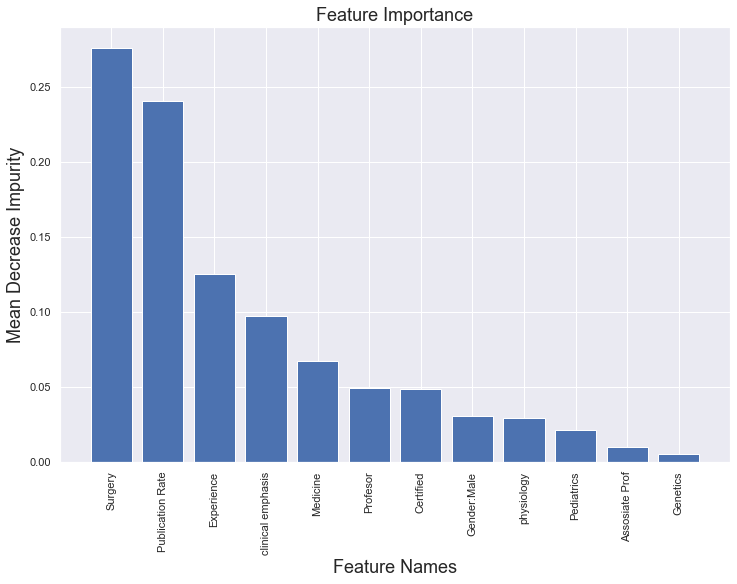

In [153]:
fig, ax = plt.subplots(figsize=(12,8))
# create a bar plot of the sorted DataFrame
plt.bar(result_forest['Feature Name'], result_forest['Score'])
plt.xticks(rotation=90)
plt.xlabel('Feature Names')
plt.ylabel('Mean Decrease Impurity')
plt.title('Feature Importance')
plt.show()

#### Lasso Regression:

In [114]:
from sklearn.linear_model import Lasso
import numpy as np

# Assuming X is your feature matrix and y is the target variable
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_lasso = dummy_data.drop(columns=['Sal94'])
Y_lasso = lawsuit['Sal94']


# Create a Lasso regression object
lasso = Lasso(alpha=0.1, max_iter=10000)

# Fit the model on the training data
lasso.fit(X_lasso, Y_lasso)

# Get the feature importance
coef = np.abs(lasso.coef_)
print(coef)

# Creating DataFrame to store Feature importance
result_lasso = pd.DataFrame()
feature_names = ['Publication Rate', 'Experience',"physiology", 'Genetics', 'Pediatrics','Medicine','Surgery','Gender:Male','clinical emphasis','Certified','Assosiate Prof','Profesor']
result_lasso["Feature Name"] = feature_names
result_lasso["Score"] = coef
# Sorting scores in descending order:
result_lasso = result_lasso.sort_values(by='Score', ascending=False)
result_lasso

[  6406.12592222  18750.58818534  11966.27723384  22364.43390887
  19916.37599042  72701.08328497 169244.39598415   2801.59376498
  15839.2575792   19562.92868633  17216.68724253  33873.46188719]


,Feature Name,Score
6,Surgery,169244.395984
5,Medicine,72701.083285
11,Profesor,33873.461887
3,Genetics,22364.433909
4,Pediatrics,19916.375990
9,Certified,19562.928686
1,Experience,18750.588185
10,Assosiate Prof,17216.687243
8,clinical emphasis,15839.257579
2,physiology,11966.277234


In [115]:
lasso_pred = model.predict(X_lasso)
r2_lasso = r2_score(Y_lasso, lasso_pred)
rmse_lasso = np.sqrt(mean_squared_error(Y_lasso, lasso_pred))

# print R-squared and RMSE
print("R-squared:", r2)
print("RMSE:", rmse)

R-squared: 0.9858889167853598
RMSE: 24878.00494555392


##### Visualising Lasso Coefficients:


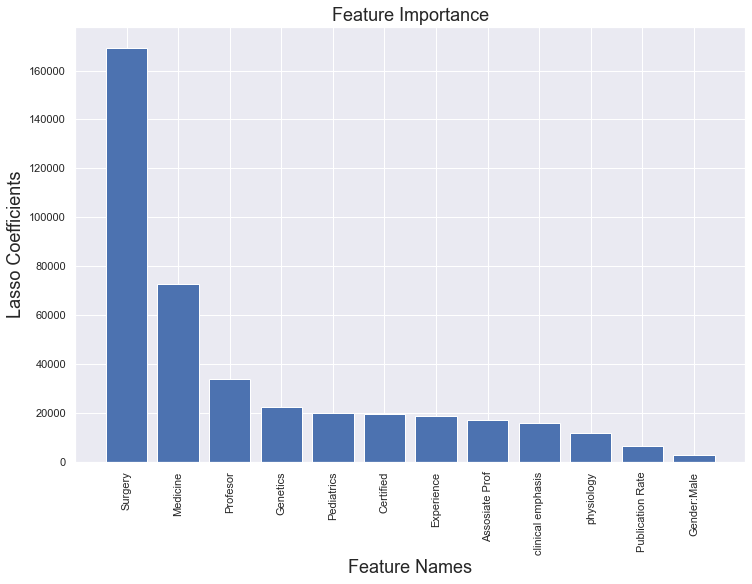

In [102]:
fig, ax = plt.subplots(figsize=(12,8))
# create a bar plot of the sorted DataFrame

plt.bar(result_lasso['Feature Name'], result_lasso['Score'])
plt.xticks(rotation=90)
plt.xlabel('Feature Names')
plt.ylabel('Lasso Coefficients')
plt.title('Feature Importance')
plt.show()

### Classification Models:

Q2 : Is gender a significant differentiator in the rank of a faculty member?

To answer this question, 3 classification models - logistic regression, CART and  random forest classifier will be used to to determine the importance of the features on the prediction of rank.

The 'Sal94' was not used in the predection of rank as the previous regression models show that rank has a notable impact on the salary of a faculty memeber. So instead all the remaining features were used to determine in the models to predict rank.


##### Creating dummy variables for classification models:


In [45]:
# Creating Dummy Variables for Classification Models:
# Rank not being encoded:
dummy_datac = pd.get_dummies(lawsuit, columns=['Dept', 'Gender', 'Clin', 'Cert'], drop_first=True)
dummy_datac

,Prate,Exper,Rank,Sal94,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6,Gender_1,Clin_1,Cert_1
0,7.4,9,3,77836,0,0,0,0,0,1,0,0
1,6.7,10,2,69994,0,0,0,0,0,1,0,0
2,8.1,6,1,62872,0,0,0,0,0,1,0,0
3,5.1,27,3,155196,0,0,0,0,0,1,1,1
4,7.0,10,3,89268,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
256,2.9,8,2,297174,0,0,0,0,1,0,1,1
257,2.6,9,3,308081,0,0,0,0,1,0,1,1
258,2.8,8,1,211269,0,0,0,0,1,0,1,1
259,2.4,2,1,210801,0,0,0,0,1,0,1,1


##### Scaling continuous variables and dropping 'Sal94':

In [46]:
# Select only the continuous columns
num_cols = ['Prate', 'Exper']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the selected columns
dummy_datac[num_cols] = scaler.fit_transform(dummy_datac[num_cols])

dummy_data_class = dummy_datac.drop(columns=['Sal94'])
dummy_data_class

,Prate,Exper,Rank,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6,Gender_1,Clin_1,Cert_1
0,1.271611,-0.197882,3,0,0,0,0,0,1,0,0
1,0.910916,-0.036987,2,0,0,0,0,0,1,0,0
2,1.632305,-0.680567,1,0,0,0,0,0,1,0,0
3,0.086472,2.698227,3,0,0,0,0,0,1,1,1
4,1.065500,-0.036987,3,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
256,-1.047139,-0.358777,2,0,0,0,0,1,0,1,1
257,-1.201722,-0.197882,3,0,0,0,0,1,0,1,1
258,-1.098667,-0.358777,1,0,0,0,0,1,0,1,1
259,-1.304778,-1.324147,1,0,0,0,0,1,0,1,1


#### Logistic Regression:

In [47]:
Y_log = dummy_data_class['Rank']
X_log = dummy_data_class.drop(columns=['Rank'])

# Fitting multinomial logistic regression model:
model = sm.MNLogit(Y_log, X_log).fit(method='newton', maxiter=100)

# Printing summary of model 
print(model.summary())
# this is primary to see coefficients and p values:

Optimization terminated successfully.
         Current function value: 0.692023
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                   Rank   No. Observations:                  261
Model:                        MNLogit   Df Residuals:                      241
Method:                           MLE   Df Model:                           18
Date:                Sun, 02 Apr 2023   Pseudo R-squ.:                  0.3551
Time:                        16:26:17   Log-Likelihood:                -180.62
converged:                       True   LL-Null:                       -280.07
Covariance Type:            nonrobust   LLR p-value:                 1.653e-32
    Rank=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Prate          0.0047      0.352      0.013      0.989      -0.684       0.694
Exper          2.8202      0.

##### Calculating odds ratio confidence interval:

In [48]:
params = model.params
conf = model.conf_int()
conf.columns = ['Upper', 'Lower']
# Printing exponent of coefficient confidence interval - Odds Ratio
print(np.exp(conf))

                   Upper      Lower
Rank                               
2    Prate      0.504394   2.001127
     Exper      7.171400  39.260340
     Dept_2     0.816406  13.029997
     Dept_3     0.345672   6.582874
     Dept_4     0.806929  22.878933
     Dept_5     0.391849   6.318240
     Dept_6     0.167656   6.510742
     Gender_1   1.537162   7.944378
     Clin_1     0.243472   3.071877
     Cert_1     0.120128   0.950414
3    Prate      0.309185   1.408462
     Exper     15.733890  95.644343
     Dept_2     0.855233  15.209522
     Dept_3     0.273893   6.734414
     Dept_4     0.095112   4.668251
     Dept_5     0.129243   2.553566
     Dept_6     0.030987   1.656883
     Gender_1   2.087065  12.667740
     Clin_1     0.174229   2.580358
     Cert_1     0.231419   2.100565


### CART: 

In [66]:
Y_cart = dummy_data_class['Rank']
X_cart = dummy_data_class.drop(columns=['Rank'])

cart_model = DecisionTreeClassifier(min_samples_split=2, ccp_alpha=0)
# Fitting the model:
cart_model.fit(X_cart, Y_cart)

importances = cart_model.feature_importances_


result_CART = pd.DataFrame()
feature_classes = ['Publication Rate','Experience','Physiology','Genetics','Pediatrics','Medicine','Surgery','Gender:Male','Clinical Emphasis','Certified']
result_CART["Feature Name"] = feature_classes
result_CART['Score'] = importances

# Sorting scores in descending order:
result_CART = result_CART.sort_values(by='Score', ascending=False)
result_CART = result_CART.T
result_CART



,1,0,9,5,2,4,7,8,6,3
Feature Name,Experience,Publication Rate,Certified,Medicine,Physiology,Pediatrics,Gender:Male,Clinical Emphasis,Surgery,Genetics
Score,0.605485,0.226206,0.047007,0.030767,0.02386,0.019076,0.016513,0.013112,0.011571,0.006404


### Random Forest:

In [56]:
Y_forestc = dummy_data_class['Rank']
X_forestc = dummy_data_class.drop(columns=['Rank'])

rfc = RandomForestClassifier(n_estimators=500, max_features=3, random_state=42)

In [68]:
# Fitting the model:
rfc.fit(X_forestc,Y_forestc)

# Get the feature importances
importances = rfc.feature_importances_
# Creating DataFrame to store Feature importance
#importancesc
result_forest_c = pd.DataFrame()
#feature_names = ['Publication Rate', 'Experience',"physiology", 'Genetics', 'Pediatrics','Medicine','Surgery','Gender:Male','clinical emphasis','Certified']
result_forest_c["Feature Name"] = feature_classes
result_forest_c["Score"] = importances
# Sorting scores in descending order:
result_forest_c = result_forest_c.sort_values(by='Score', ascending=False)
result_forest_c = result_forest_c.T
result_forest_c

#result_forest_c = result_forest_c.sort_values(by='Score', ascending=False)

,1,0,7,9,8,5,2,4,6,3
Feature Name,Experience,Publication Rate,Gender:Male,Certified,Clinical Emphasis,Medicine,Physiology,Pediatrics,Surgery,Genetics
Score,0.530279,0.245879,0.071055,0.03988,0.026427,0.020504,0.020367,0.019747,0.013578,0.012284
